# RQ3

How does the embedding model influence resource and energy use?

In [1]:
%load_ext autoreload
%autoreload 2

import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from results_processor import get_experiments_data, compute_total_energy_per_run, get_ci_deviation, compute_wilcoxon

plt.style.use("ggplot")
colors = sns.cubehelix_palette(start=2, rot=0.1, dark=0.2, light=.95, reverse=True)

In [2]:
experiments_data = get_experiments_data(
    "rq3",
    ["Total DRAM Power [W]", "IA Cores Power [W]", "GPU Rail Powers (avg) [W]"],
    idle_state="Docker running",
)

runs_data = compute_total_energy_per_run(experiments_data)

In [3]:
embedding_variation_runs = []

for embedding_model_name, data in runs_data.items():
    data_embedding_variation = copy.deepcopy(data["measurements_per_run"])
    data_embedding_variation["duration [s]"] = data["durations_per_run"]
    data_embedding_variation["model"] = embedding_model_name.replace(
        "_nfcorpus", ""
    ).replace("_", "-")

    embedding_variation_runs.append(data_embedding_variation)

embedding_variation_runs = pd.concat(embedding_variation_runs)

In [4]:
embedding_variation_runs.groupby("model").aggregate(
    lambda x: str(round(x.mean(), 2)) + " ± " + str(get_ci_deviation(x))
)

,CPU Cores Energy [J],DRAM Energy [J],GPU Energy [J],duration [s]
model,,,,
gte-base,314.81 ± 5.35,19.31 ± 0.4,7894.51 ± 25.4,242.31 ± 0.37
gte-large,792.99 ± 122.57,36.02 ± 5.18,19563.35 ± 24.57,621.28 ± 0.37
gte-small,198.31 ± 2.63,15.8 ± 0.29,2379.56 ± 13.25,89.62 ± 0.09


In [5]:
total_consumption_per_embedding_type = embedding_variation_runs.groupby("model").sum()
total_consumption_smallest_embedding = (
    embedding_variation_runs.groupby("model").sum().iloc[2, :]
)

consumption_ratio = total_consumption_per_embedding_type / total_consumption_smallest_embedding
consumption_ratio = consumption_ratio.sort_values("duration [s]")
consumption_ratio

,CPU Cores Energy [J],DRAM Energy [J],GPU Energy [J],duration [s]
model,,,,
gte-small,1.000000,1.000000,1.000000,1.000000
gte-base,1.587454,1.222507,3.317629,2.703557
gte-large,3.998725,2.280451,8.221402,6.932061


In [6]:
embedding_model = consumption_ratio.index.to_list() * len(consumption_ratio.columns)

consumption_ratio = consumption_ratio.melt()
consumption_ratio["model"] = embedding_model

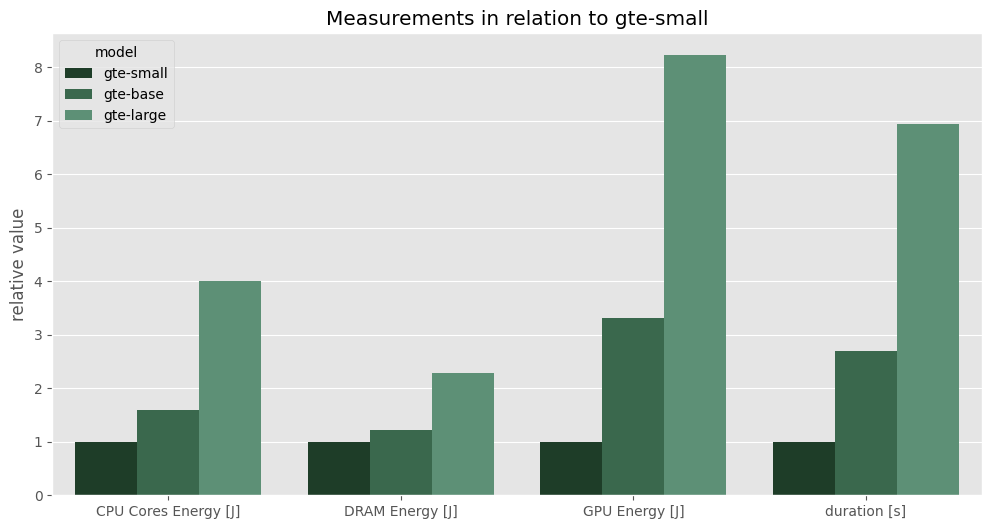

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)
sns.barplot(consumption_ratio, x="variable", y="value", hue="model", palette=colors)
plt.ylabel("relative value")
plt.xlabel("")
plt.title("Measurements in relation to gte-small")
fig.savefig("./x.png", dpi=500)

In [8]:
compute_wilcoxon(
    embedding_variation_runs, "gte-small", "gte-base", "GPU Energy [J]", "model"
)

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(0.0009765625))

In [9]:
compute_wilcoxon(
    embedding_variation_runs, "gte-base", "gte-large", "GPU Energy [J]", "model"
)

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(0.0009765625))

In [10]:
compute_wilcoxon(
    embedding_variation_runs, "gte-small", "gte-base", "duration [s]", "model"
)

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(0.0009765625))

In [11]:
compute_wilcoxon(
    embedding_variation_runs, "gte-base", "gte-large", "duration [s]", "model"
)

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(0.0009765625))